In [12]:
import cobra
import os
import numpy as np
from copy import copy
import re
import pandas as pd
import sys
import random
import cometspy as c
pd.set_option('display.max_rows', None)
import itertools
os.environ["GUROBI_COMETS_HOME"] = "/opt/gurobi952/linux64"


# This notebook puts together the four species multitoxin simulation more briefly. 

At the top, pick the nutrient. The list was grabbed from "growthrate_chosen4_toxin_selection.ipynb"

vEX_csn_e, EX_ura_e (low growth rate) EX_but_e, EX_ad_e (med), EX_thr__L_e (med), EX_tre_e 

In [13]:
# low growth rate nutrients
low_gr = ["EX_csn_e", "EX_ura_e"]
# med growth rate nutrients
med_gr = ["EX_but_e", "EX_ad_e", "EX_thr__L_e"]
# high growth rate
high_gr = ["EX_tre_e"]

carbon_source = "EX_tre_e"

In [14]:

unlimited = ["EX_ca2_e","EX_cl_e","EX_co2_e","EX_cobalt2_e","EX_cu2_e",
             "EX_fe2_e","EX_fe3_e","EX_h_e","EX_h2o_e","EX_k_e","EX_mg2_e",
             "EX_mn2_e","EX_mobd_e","EX_na1_e","EX_nh4_e","EX_ni2_e",
             "EX_o2_e","EX_pi_e","EX_sel_e","EX_slnt_e","EX_so4_e",
             "EX_tungs_e","EX_zn2_e"]


model_dir = "./models/"

model_shortnames = {"B" : "ST32113_grampos",
             "F" : "ST32123_grampos",
             "G" : "ST32124_grampos",
             "I" :"ST32133_grampos"}

model_ids = list(model_shortnames.values())
B = cobra.io.read_sbml_model(model_dir + model_shortnames["B"] + "_2022gapclosed.xml")
B.id = "B"
F = cobra.io.read_sbml_model(model_dir + model_shortnames["F"] + "_2022gapclosed.xml")
F.id = "F"
G = cobra.io.read_sbml_model(model_dir + model_shortnames["G"] + "_2022gapclosed.xml")
G.id = "G"
I = cobra.io.read_sbml_model(model_dir + model_shortnames["I"] + "_2022gapclosed.xml")
I.id = "I"

In [15]:

### Make the cobra models which make toxin, export it, and see it
from cobra import Metabolite, Reaction

B_toxin_c = Metabolite("B_toxin_c", compartment = "C_c")
B_toxin_e = Metabolite("B_toxin_e", compartment = "C_e")
B_objective = B.reactions.Growth
# arbitrarily have one unit of toxin produced for 1 gram of cells
B_objective.add_metabolites({B_toxin_c: 1.})
B_toxin_tpp = Reaction("B_toxin_tpp", 
                       lower_bound = 0, upper_bound = 1000)
B_toxin_tpp.add_metabolites({B_toxin_c : -1,
                       B_toxin_e: 1})
B.add_reactions([B_toxin_tpp])
B.add_boundary(B_toxin_e, type = "exchange",
               lb = 0, ub = 1000)



F_toxin_c = Metabolite("F_toxin_c", compartment = "C_c")
F_toxin_e = Metabolite("F_toxin_e", compartment = "C_e")
F_objective = F.reactions.Growth
# arbitrarily have one unit of toxin produced for 1 gram of cells
F_objective.add_metabolites({F_toxin_c: 1.})
F_toxin_tpp = Reaction("F_toxin_tpp", 
                       lower_bound = 0, upper_bound = 1000)
F_toxin_tpp.add_metabolites({F_toxin_c : -1,
                       F_toxin_e: 1})
F.add_reactions([F_toxin_tpp])
F.add_boundary(F_toxin_e, type = "exchange",
               lb = 0, ub = 1000)


G_toxin_c = Metabolite("G_toxin_c", compartment = "C_c")
G_toxin_e = Metabolite("G_toxin_e", compartment = "C_e")
G_objective = G.reactions.Growth
# arbitrarily have one unit of toxin produced for 1 gram of cells
G_objective.add_metabolites({G_toxin_c: 1.})
G_toxin_tpp = Reaction("G_toxin_tpp", 
                       lower_bound = 0, upper_bound = 1000)
G_toxin_tpp.add_metabolites({G_toxin_c : -1,
                       G_toxin_e: 1})
G.add_reactions([G_toxin_tpp])
G.add_boundary(G_toxin_e, type = "exchange",
               lb = 0, ub = 1000)


# B needs to see F,G
# F needs to see B,G
#G needs to see B, F
#I needs to see B

B.add_boundary(F_toxin_e, type = "exchange",
               lb = 0, ub = 0)
B.add_boundary(G_toxin_e, type = "exchange",
               lb = 0, ub = 0)
F.add_boundary(B_toxin_e, type = "exchange",
               lb = 0, ub = 0)
F.add_boundary(G_toxin_e, type = "exchange",
               lb = 0, ub = 0)
G.add_boundary(B_toxin_e, type = "exchange",
               lb = 0, ub = 0)
G.add_boundary(F_toxin_e, type = "exchange",
               lb = 0, ub = 0)
I.add_boundary(B_toxin_e, type = "exchange",
               lb = 0, ub = 0)

Reaction identifier,EX_B_toxin_e
Name,exchange
Memory address,0x07fd6c0955df0
Stoichiometry,B_toxin_e --> -->
GPR,
Lower bound,0
Upper bound,0


## Here, I am setting the max growth rate for ALL species to be the same--the minimum across species on the carbon source. 

In [16]:
cobra_medium = {key: 10. for key in unlimited}
cobra_medium
cobra_medium[carbon_source] = 10.

B.medium = {k:10. for k,v in cobra_medium.items() if k in [e.id for e in B.exchanges]}
B_gr = B.slim_optimize(0)
F.medium = {k:10. for k,v in cobra_medium.items() if k in [e.id for e in F.exchanges]}
F_gr = F.slim_optimize(0)
G.medium = {k:10. for k,v in cobra_medium.items() if k in [e.id for e in G.exchanges]}
G_gr = G.slim_optimize(0)
I.medium = {k:10. for k,v in cobra_medium.items() if k in [e.id for e in I.exchanges]}
I_gr = I.slim_optimize(0)
print(f"growth rates = {[B_gr, F_gr, G_gr, I_gr]}")
min_gr = min([B_gr, F_gr, G_gr, I_gr])
print(f"min growth rate = {min_gr}")

growth rates = [0.9565404522889523, 0.956540452288932, 0.9565404522889304, 0.956540452288943]
min growth rate = 0.9565404522889304


In [17]:
B_comets = c.model(B)
B_comets.id = "B"
F_comets = c.model(F)
F_comets.id = "F"
G_comets = c.model(G)
G_comets.id = "G"
I_comets = c.model(I)
I_comets.id = "I"

B_comets.open_exchanges()
F_comets.open_exchanges()
G_comets.open_exchanges()
I_comets.open_exchanges()

B_comets.initial_pop = [[0,0, 0.01]]
F_comets.initial_pop = [[0,0, 0.01]]
G_comets.initial_pop = [[0,0, 0.01]]
I_comets.initial_pop = [[0,0, 0.01]]

B_comets.add_multitoxin(2138, [229, 230], "ub", min_gr, [2.e-5, 2.e-5], [5,5])

F_comets.add_multitoxin(2246, [265, 264], "ub", min_gr, [2.e-5, 2.e-5], [5,5])

G_comets.add_multitoxin(2139, [234], "ub", min_gr, [1.e-3], [5])

I_comets.add_multitoxin(2488, [275], "ub", min_gr, [1], [5])



/home/jeremy/miniconda3/envs/comets/lib/python3.8/site-packages/cometspy/model.py:185: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.multitoxins = self.multitoxins.append(new_row, ignore_index=True)
/home/jeremy/miniconda3/envs/comets/lib/python3.8/site-packages/cometspy/model.py:185: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.multitoxins = self.multitoxins.append(new_row, ignore_index=True)
/home/jeremy/miniconda3/envs/comets/lib/python3.8/site-packages/cometspy/model.py:185: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.multitoxins = self.multitoxins.append(new_row, ignore_index=True)
/home/jeremy/miniconda3/envs/comets/lib/python3.8/site-packages/cometspy/model.py:185: FutureWarning: The frame.append me

## Spatial environment

In [18]:
params = c.params()
params.set_param("timeStep", .1) # probably this needs to be reduced dramatically
params.set_param("maxCycles", 200)
params.set_param("spaceWidth", 0.02) # cm, changing this will influence toxicity, need t play with
params.set_param("defaultKm", 0.000001)
params.set_param("maxSpaceBiomass", 1000)
params.set_param("minSpaceBiomass", 1.e-15)
params.set_param("writeMediaLog", False)
params.set_param("MediaLogRate", 1)
params.set_param("writeFluxLog", False)
params.set_param("FluxLogRate", 1)


In [19]:
def pick_unique_locations(width, height, n, edge_space = 0):
    locs = []
    while len(locs) < n:
        loc = (random.randrange(edge_space, width - edge_space),
               random.randrange(edge_space, height - edge_space))
        if loc not in locs:
            locs.append(loc)
    return(locs)

grid_size =[30, 30] 

locs = pick_unique_locations(grid_size[0], grid_size[1], 40, 3)
B_locs = locs[0:10]
F_locs = locs[10:20]
G_locs = locs[20:30]
I_locs = locs[30:40]


In [20]:
initial_biomass = 1.e-10
B_comets.initial_pop = [[loc[0], loc[1], initial_biomass] for loc in B_locs]
F_comets.initial_pop = [[loc[0], loc[1], initial_biomass] for loc in F_locs]
G_comets.initial_pop = [[loc[0], loc[1], initial_biomass] for loc in G_locs]
I_comets.initial_pop = [[loc[0], loc[1], initial_biomass] for loc in I_locs]


layout = c.layout([B_comets,F_comets,G_comets,I_comets])
layout.grid = grid_size
for met in unlimited:
    met = met[3:]
    if met in layout.media.metabolite.values:
        layout.set_specific_metabolite(met, 1000.)
layout.set_specific_metabolite(carbon_source[3:], 4.e-7)




# Reduce the diffusion constant of the toxin by a factor of 10

In [21]:
layout.media.loc[layout.media.metabolite =="B_toxin_e", "diff_c"] = 5.e-7
layout.media.loc[layout.media.metabolite =="F_toxin_e", "diff_c"] = 5.e-7
layout.media.loc[layout.media.metabolite =="G_toxin_e", "diff_c"] = 5.e-7


Running COMETS simulation ...
Done!


<AxesSubplot:xlabel='cycle'>

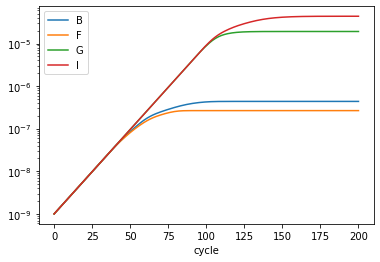

In [22]:
sim = c.comets(layout, params)
sim.VERSION = "comets_multitoxin"
sim.set_classpath("bin", '/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_multitoxin.jar')
sim.run(delete_files = True)
baseline = sim.total_biomass
baseline.plot(x = "cycle", logy = True)